In [1]:
from google.colab import drive
drive.mount('/content/drive')

%load_ext autoreload
%autoreload 2

import os
#change to desired path
os.chdir("./drive/MyDrive/Research")
%pwd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'/content/drive/MyDrive/Research'

In [2]:
%pip install torch datasets transformers tqdm matplotlib tiktoken numpy

In [3]:
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset
from utils import setup_logging, CfgNode as CN
from trainer import Trainer
from model import GPT
import numpy as np
import tiktoken
from prepro_tinyshakespeare import download, tokenize

In [4]:
class TinyShakespeareDataset(Dataset):
    def __init__(self, token_array, block_size):
        self.token_array = token_array
        self.block_size = block_size

    def __len__(self):
        return len(self.token_array) - self.block_size

    def __getitem__(self, idx):
        x = torch.tensor(self.token_array[idx:idx + self.block_size], dtype=torch.long)
        y = torch.tensor(self.token_array[idx + 1:idx + self.block_size + 1], dtype=torch.long)
        return x, y

In [5]:
def load_tinyshakespeare(block_size, data_dir):
    train_data_path = os.path.join(data_dir, "tiny_shakespeare_train.bin")
    train_data = np.fromfile(train_data_path, dtype=np.int32)

    train_dataset = TinyShakespeareDataset(train_data, block_size)
    return train_dataset

In [6]:
def run_training(trainer, total_iters, early_stop_threshold):
    # Initialize tqdm progress bar
    pbar = tqdm(total=total_iters, desc="Training progress", leave=True)

    train_losses = []
    best_loss = float('inf')
    no_improve_count = 0

    def update_progress(trainer):
        pbar.update(1)
        current_loss = trainer.loss.item()
        train_losses.append(current_loss)
        pbar.set_postfix_str(f"Loss: {current_loss:.4f}")

        nonlocal best_loss, no_improve_count
        if current_loss < best_loss:
            best_loss = current_loss
            no_improve_count = 0
        else:
            no_improve_count += 1
        if no_improve_count >= early_stop_threshold:
            pbar.close()
            raise StopIteration("Early stopping triggered")

    trainer.add_callback('on_batch_end', update_progress)

    try:
        trainer.run()
    except StopIteration as e:
        print(str(e))
    finally:
        try:
            pbar.close()
        except:
            pass

    return train_losses

In [20]:
C = CN()
C.system = CN()
C.system.work_dir = './out'
setup_logging(C)

C.model = GPT.get_default_config()
C.model.model_type = 'gpt-micro'
C.model.vocab_size = 50257
C.model.block_size = 128

C.trainer = Trainer.get_default_config()
C.trainer.learning_rate = 5e-4
C.trainer.max_iters = 10000

model_path = os.path.join(C.system.work_dir, 'model.pt')
early_stop_threshold = 25
data_dir = "./data"

In [8]:
model = GPT(C.model)

number of parameters: 14.32M


In [9]:
download()
tokenize()
train_dataset = load_tinyshakespeare(C.model.block_size, data_dir)
trainer = Trainer(C.trainer, model, train_dataset)
losses = run_training(trainer, C.trainer.max_iters, early_stop_threshold)

data/tiny_shakespeare.txt already exists, skipping download...
Saved 32768 tokens to data/tiny_shakespeare_val.bin
Saved 305260 tokens to data/tiny_shakespeare_train.bin
running on device cuda


Training progress:   0%|          | 0/10000 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Training progress:   4%|▍         | 387/10000 [07:18<3:01:36,  1.13s/it, Loss: 4.4631]

Early stopping triggered


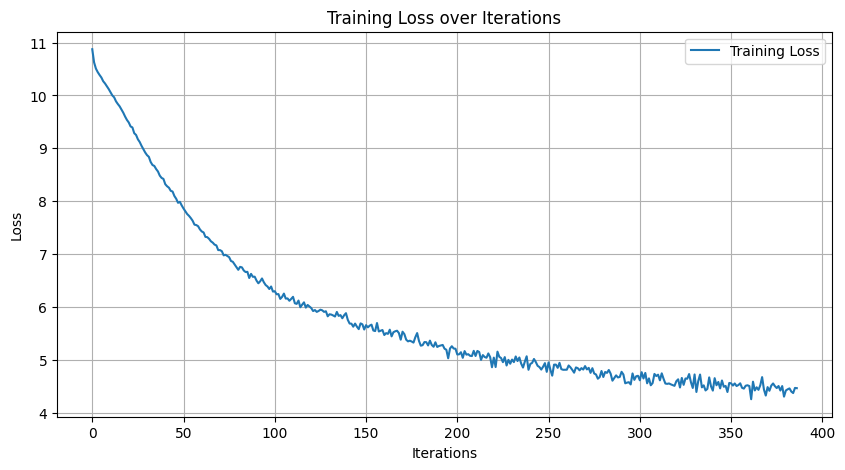

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(losses, label='Training Loss')
plt.title('Training Loss over Iterations')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

Model saved to ./out/model.pt


In [12]:
encoder = tiktoken.get_encoding("gpt2")
encode = lambda s: encoder.encode(s, allowed_special={'<|endoftext|>'})

In [21]:
model = GPT(C.model)
model.load_state_dict(torch.load(model_path))
model.eval()
input_phrase = "Thou"
input_ids = torch.tensor([encode(input_phrase)], dtype=torch.long)

with torch.no_grad():
    output = model.generate(input_ids, max_new_tokens=100, temperature=1, do_sample=True)

generated_text = ''.join(encoder.decode(output[0].tolist()))
print(f"Generated text: {generated_text}")

number of parameters: 14.32M
Generated text: Thou rest woo ten aunt of his news?

<|endoftext|>QUEENES:
 Senator: is gone.

<|endoftext|>KING EDWARD IV:
que title--UM'd, sir, besthood, then no comes Romeo he short walls!

<|endoftext|> bracelet, as thou have a woman and
Shall you and his queen'd our patience:
unes, and far as thou any matter?
What
He was sent, say, charity.
a counsel; and they do B way she
